In [2]:
import timeit
from datetime import timedelta
import numpy as np
import pandas as pd
# from pandas_profiling import ProfileReport
# import lux # slows down dataframe processing
import matplotlib.pyplot as plt
%matplotlib inline
import joblib

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, zero_one_loss, hamming_loss, classification_report, confusion_matrix, \
                            ConfusionMatrixDisplay

np.set_printoptions(suppress=True) # do not print scientific notation

# Set some matplotlib style parameters
plt.style.use('seaborn')
plt.rcParams.update({'figure.facecolor' : 'white',
                     'figure.edgecolor' : 'white',
                     'axes.grid'        : True,
                     # 'axes.axisbelow'   : True,
                     'figure.autolayout': True # tight_layout
                    })

# Set some pandas options
pd.set_option('display.max_columns', None, # show x columns (None shows all)
              # 'display.max_rows', None,  # show x rows    (None shows all)
              'compute.use_numba', True)   # turn off for Lux

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
nb_name = 'row_by_row' # for saving objects with joblib
seed = 42
rng = np.random.default_rng(seed)

n = secure_bits = 5         # rows
m = corrected_key_bits = 10 # columns
N_vec = 1000                # nº of corrected key vectors

## Functions

### Detect power consumption of basic gates

In [3]:
def get_product_power(mat, vec, gate_powers, noise_std=0.):
    '''Returns: array with the power consumed by the gates of each product.
    Set noise_std = 0 to eliminate noise.'''
    n, m = mat.shape
    count = [[] for _ in range(n)]
    for i in range(n):
        for j in range(m):
            idx = 2 * mat[i, j] + vec[j]
            count[i].extend(gate_powers[idx] + rng.normal(scale=noise_std, size=gate_powers[idx].size))
    return count # size = n * m * gate_powers[idx].size

In [4]:
def get_sum_power(mat, vec, gate_powers, noise_std=0.):
    '''Returns: array with the power consumed by the gates of each sum.
    Set noise_std = 0 to eliminate noise.'''
    n, m = mat.shape
    count = [[] for _ in range(n)]
    for i in range(n):
        result = 0
        for j in range(m):
            next_element = mat[i, j] * vec[j]
            idx = 2 * result + next_element
            count[i].extend(gate_powers[idx] + rng.normal(scale=noise_std, size=gate_powers[idx].size))
            result = (result + next_element) % 2
    return count # size = n * m * gate_powers[idx].size

In [5]:
# # TEST
# mat = np.asarray([[0, 1, 1, 0, 1],
#                   [1, 0, 1, 1, 1],
#                   [1, 1, 1, 1, 1],
#                   [0, 0, 0, 0, 0]])
# # vec = np.asarray([0, 0, 0, 0, 0])
# # vec = np.asarray([1, 1, 1, 1, 1])
# vec = np.asarray([1, 1, 1, 0, 0])
# power_products = np.asarray([[.1, 1.1], [.2, 1.2], [.3, 1.3], [.4, 1.4]])
# power_sums = np.asarray([[1.1, 2.1], [1.2, 2.2], [1.3, 2.3], [1.4, 2.4]])

# print(mat @ vec % 2, '\n')
# count = get_product_power(mat, vec, power_products, 0.01)
# print(np.around(count, 3), '\n')
# count = get_sum_power(mat, vec, power_sums, 0.01)
# print(np.around(count, 3))

### Class

In [6]:
# Detect if there are more 1s than 0s
# def More_1_than_0(mat, vec):
#     return np.sum(mat @ vec % 2) > secure_bits / 2

# Detect full solution
def Full_solution(mat, vec):
    return mat @ vec % 2

### Other

In [7]:
# Check if input & output vectors from sample are unique
def Check_uniqueness(mat, vec):
    res = []
    for i in range(len(vec)):
        res.append(mat @ vec[i] % 2)
    unique_in  = np.unique(vec, axis=0)
    unique_out = np.unique(res, axis=0)
    return unique_in.shape[0], unique_out.shape[0]

## Generate data

In [8]:
mat = rng.integers(2, size=(secure_bits,corrected_key_bits), dtype=np.int8)

mat.shape, mat

((5, 10),
 array([[1, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 1, 1, 0, 1, 1, 0, 0]], dtype=int8))

In [9]:
vec = [rng.integers(2, size=corrected_key_bits, dtype=np.int8) for _ in range(N_vec)]

np.shape(vec), vec[0]

((1000, 10), array([0, 0, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int8))

In [10]:
unique_in, unique_out = Check_uniqueness(mat, vec)
print(f'{N_vec} inputs: {unique_in} unique inputs, {unique_out} unique solutions')

1000 inputs: 632 unique inputs, 32 unique solutions


Assumptions on power consumption (based on https://ieeexplore.ieee.org/document/6644863):
- NOT:
    - 0 - 6.73 pA
    - 1 - 7.45 pA
- 2-input NOR:
    - 00 - 13.50 pA
    - 01 - 12.80 pA
    - 10 - &nbsp; 7.93 pA
    - 11 - &nbsp; 5.93 pA
- 2-input NAND:
    - 00 - &nbsp; 5.79 pA
    - 01 - &nbsp; 7.00 pA
    - 10 - 11.77 pA
    - 11 - 14.91 pA

Writing our operations in the gates above:
- A\*B &nbsp;= AND(A, B)
= NOT(NAND(A, B))

- A+B = XOR(A, B)
= NOT(A<=>B)
= NOT(AND(A->B, B->A))
= NAND(A->B, B->A)
= NAND(OR(NOT(A), B), OR(NOT(B), A)) =  
&nbsp; &nbsp; &nbsp; &nbsp; = NAND(NOT(NOR(NOT(A), B)), NOT(NOR(NOT(B), A)))

Thus:
- 0\*0: &nbsp; &nbsp; 5.79 + 7.45 = 13.24 pA
- 0\*1: &nbsp; &nbsp; 7.00 + 7.45 = 14.45 pA
- 1\*0: &nbsp; 11.77 + 7.45 = 19.22 pA
- 1\*1: &nbsp; 14.91 + 6.73 = 21.64 pA


- 0+0: &nbsp; 6.73 + 6.73 + &nbsp; 7.93 + &nbsp; 7.93 + 6.73 + 6.73 + 14.91 = 57.69 pA
- 0+1: &nbsp; 6.73 + 7.45 + &nbsp; 5.93 + 13.50 + 6.73 + 7.45 + 11.77 = 59.56 pA
- 1+0: &nbsp; 7.45 + 6.73 + 13.50 + &nbsp; 5.93 + 7.45 + 6.73 + &nbsp; 7.00 = 54.79 pA
- 1+1: &nbsp; 7.45 + 7.45 + 12.80 + 12.80 + 6.73 + 6.73 + 14.91 = 68.87 pA

In [11]:
# Define power consumption for each gate & noise level
power_product_gates = np.asarray([[5.79, 7.45], [7., 7.45], [11.77, 7.45], [14.91, 6.73]]) # 0*0, 0*1, 1*0, 1*1
power_sum_gates = np.asarray([[6.73, 6.73, 7.93, 7.93, 6.73, 6.73, 14.91],  # '0+0' gates
                              [6.73, 7.45, 5.93, 13.5, 6.73, 7.45, 11.77],  # '0+1' gates
                              [7.45, 6.73, 13.5, 5.93, 7.45, 6.73, 7.],     # '1+0' gates
                              [7.45, 7.45, 12.8, 12.8, 6.73, 6.73, 14.91]]) # '1+1' gates
noise_std = 0.05 + 0.0 # article measurement precision + hacker device noise

In [12]:
# i = 0
# print('Products:\n', np.around(get_product_power(mat, vec[i], power_product_gates, noise_std), 3))
# print('Sums:\n', np.around(get_sum_power(mat, vec[i], power_sum_gates, noise_std), 3))

In [13]:
# print("Full solution")
# print("-------------")
# for i in range(10):
#     print(Full_solution(mat, vec[i]))

In [14]:
# Order data by time (row by row)
data = [[] for _ in range(N_vec)]
for i in range(N_vec):
    product_power = get_product_power(mat, vec[i], power_product_gates, noise_std)
    sum_power     = get_sum_power(mat, vec[i], power_sum_gates, noise_std)
    for j in range(n):
        data[i].extend(product_power[j])
        data[i].extend(sum_power[j])
    data[i].extend(Full_solution(mat, vec[i]))

data = np.asarray(data)
data.shape

(1000, 455)

In [15]:
# Lower data sampling
sampling_interval = 3 # in gates
data_low_sampling = data[:, 0:-n:sampling_interval]
data_low_sampling = np.append(data_low_sampling, data[:, -n:], axis=1)

data_low_sampling.shape

(1000, 155)

In [16]:
# Create dataframe with raw data
df = pd.DataFrame(data_low_sampling)
df.drop_duplicates(inplace=True, ignore_index=True)
# np.around(df, 3)

In [ ]:
# Plot full power consumption through time
y = df.iloc[0][:-n]
X = np.arange(len(y))

# Plot line
plt.figure(figsize=(16, 4))
plt.plot(X, y, '-', label='Record 0') # colors: b,g,r,c,m,y,k,w
plt.xlim(X.min(), X.max()*1.01)
plt.ylim(y.min()*0.925, y.max()*1.075)
# plt.xticks(np.arange(0, len(y)+1, 250))
# plt.yticks(np.arange(6, 16.1, 2))

# Set labels
plt.legend() # loc='best', 'upper right', 'lower left', ...
plt.xlabel('Data point')
plt.ylabel('Power consumption ($pA$)')
plt.title('Total Power consumption', fontsize=14)

# plt.savefig(f'Results/Other/power_consumption_total_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.png', dpi=200)
plt.show()

# Plot power consumption of one row through time
line_length = int(np.ceil(m * (power_product_gates.shape[1] + power_sum_gates.shape[1]) / sampling_interval))
X = np.arange(line_length)
y = df.iloc[0][:line_length]

# Plot line
plt.figure(figsize=(16, 4))
plt.plot(X, y, '-', label='Record 0') # colors: b,g,r,c,m,y,k,w
plt.xlim(X.min(), X.max()*1.01)
# plt.ylim(y.min()*0.925, y.max()*1.075)
# plt.xticks(np.arange(0, line_length+1, 10))
# plt.yticks(np.arange(6, 16.1, 2))

# Set labels
plt.legend() # loc='best', 'upper right', 'lower left', ...
plt.xlabel('Data point')
plt.ylabel('Power consumption ($pA$)')
plt.title('Power consumption of one row', fontsize=14)

# plt.savefig(f'Results/Other/power_consumption_one_row_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.png', dpi=200)
plt.show()

In [ ]:
# FULL RESOLUTION (1 gate) ----- # Plot full power consumption through time
y = df.iloc[0][:-n]
X = np.arange(len(y))

# Plot line
plt.figure(figsize=(16, 4))
plt.plot(X, y, '-', label='Record 0') # colors: b,g,r,c,m,y,k,w
plt.xlim(X.min(), X.max()*1.01)
plt.ylim(y.min()*0.925, y.max()*1.075)
# plt.xticks(np.arange(0, len(y)+1, 1000))
# plt.yticks(np.arange(6, 16.1, 2))

# Set labels
plt.legend() # loc='best', 'upper right', 'lower left', ...
plt.xlabel('Data point')
plt.ylabel('Power consumption ($pA$)')
plt.title('Total Power consumption', fontsize=14)

# plt.savefig(f'Results/Other/power_consumption_total_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.png', dpi=200)
plt.show()

# Plot power consumption of one row through time
line_length = m * (power_product_gates.shape[1] + power_sum_gates.shape[1])
X = np.arange(line_length)
y = df.iloc[0][:line_length]

# Plot line
plt.figure(figsize=(16, 4))
plt.plot(X, y, '-', label='Record 0') # colors: b,g,r,c,m,y,k,w
plt.xlim(X.min(), X.max()*1.01)
# plt.ylim(y.min()*0.925, y.max()*1.075)
# plt.xticks(np.arange(0, line_length+1, 25))
# plt.yticks(np.arange(6, 16.1, 2))

# Set labels
plt.legend() # loc='best', 'upper right', 'lower left', ...
plt.xlabel('Data point')
plt.ylabel('Power consumption ($pA$)')
plt.title('Power consumption of one row', fontsize=14)

# plt.savefig(f'Results/Other/power_consumption_one_row_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.png', dpi=200)
plt.show()

In [ ]:
# # Drop columns with equal values (worthless with noise)
# def duplicate_columns(df):
#     groups = df.columns.to_series().groupby(df.dtypes).groups
#     dups = []
#     for t, v in groups.items():
#         dcols = df[v].to_dict(orient='list')
#         vs = list(dcols.values())
#         ks = list(dcols.keys())
#         for i in range(len(vs)):
#             for j in range(i+1, len(vs)):
#                 if vs[i] == vs[j]: 
#                     dups.append(ks[i])
#                     break
#     if dups: print('Duplicate columns:', *dups)
#     return dups

# df.drop(duplicate_columns(df), axis=1, inplace=True)
# np.around(df, 3)

In [ ]:
# # Check some trends in data (turn off numba engine first)
# pd.set_option('compute.use_numba', False)
# df2 = df.copy()
# df2.intent = [90] # More_1_than_0
# display(df2)
# pd.set_option('compute.use_numba', True)

In [ ]:
# # Generate pandas profiling report
# profile = ProfileReport(
#     df, title=f'Row_by_row Low_Sampling={sampling_interval}_Noisy_Power_per_Gate noise_std={noise_std} Dataset Report',
#     explorative=True)
# # profile.to_widgets()
# profile.to_file(f'Docs/Row_by_row_-_Low_Sampling={sampling_interval}_Noisy_Power_per_Gate_noisestd={noise_std}_report.html')

### Split data

In [17]:
# Split data into training & test set
X = np.asarray(df.iloc[:, :-n], order='C')
y = np.asarray(df.iloc[:, -n:], order='C')
assert X.flags['C_CONTIGUOUS']
assert y.flags['C_CONTIGUOUS']

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=seed)

nao sei se divido rows com diferente nº de gates em dois dataframes ou se adiciono uma coluna neutra no inicio/fim às rows com menos gates.

In [18]:
# Separate X data by matrix rows
row_limits = [int(np.ceil(m * (power_product_gates.shape[1] + power_sum_gates.shape[1]) * row / sampling_interval))
              for row in range(n+1)]
n_gates_per_row = max([row_limits[i+1] - row_limits[i] for i in range(n)])
print(f'Row limits: {row_limits}\n'
      f'Max gates per row: {n_gates_per_row}')

Xs = []
for X in [X_train_raw, X_test_raw]:
    k = len(X)
    Xs.append(np.empty((n * k, n_gates_per_row))) # does not initialize entries!

    for i in range(k):
        for j in range(n):
            # Get jth-row data
            data_row_i = X[i, row_limits[j]:row_limits[j+1]]

            # Augment rows with less data points
            if data_row_i.shape[0] != n_gates_per_row:
                data_row_i = np.insert(data_row_i, -1, 0.) # insert 0 at the beginning
                # data_row_i = np.append(data_row_i, 0.)   # insert 0 at the end

            Xs[-1][i * n + j] = data_row_i.copy()

X_train, X_test = Xs
np.shape(X_train), np.shape(X_test)

Row limits: [0, 30, 60, 90, 120, 150]
Max gates per row: 30


((4000, 30), (1000, 30))

In [19]:
# Separate y data by target bit
y_train = y_train_raw.ravel('C')
y_test  = y_test_raw.ravel('C')
print(f'1s in train set: {y_train.mean():.2%}\n'
      f'1s in test set:  {y_test.mean():.2%}')

1s in train set: 50.95%
1s in test set:  51.50%


In [20]:
# Save test set
test_set = {'X_test': X_test,
            'y_test': y_test}
joblib.dump(test_set, f'Data/test_set_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib', compress=3)

['Data/test_sets_row_by_row_32x64_noise_std=0.05_sampling=30.joblib']

In [ ]:
# Delete unused variables to free some memory
del df, data_low_sampling, X, y, X_train_raw, X_test_raw, y_train_raw, y_test_raw

## Classifiers

### Functions to train & test models

In [20]:
# Train model with stratified k-fold cross-validation & get statistics
def Train_stratCV(model, X, y, n_splits=5, seed=seed):
    start_time = timeit.default_timer()
    lst_acc, lst_wrong_keys = [], []
    skf = StratifiedKFold(n_splits, shuffle=True, random_state=seed)

    # Train & test each fold
    for train_idx, test_idx in skf.split(X, y):
        x_train_fold, x_test_fold = X[train_idx], X[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]
        model.fit(x_train_fold, y_train_fold)

        lst_acc.append(model.score(x_test_fold, y_test_fold))
        y_pred_fold = model.predict(x_test_fold)

        # Group y data by key
        y_test_grouped = y_test_fold.reshape((-1, n))
        y_pred_grouped = y_pred_fold.reshape((-1, n))
        lst_wrong_keys.append(zero_one_loss(y_test_grouped, y_pred_grouped))

    delta_time = timedelta(seconds=round(timeit.default_timer()-start_time))
    print(f'\nList of accuracies:         {np.around(lst_acc, 4) * 100}\n'
          # f'Min/max accuracy:           {min(lst_acc):.2%} <---> {max(lst_acc):.2%}\n'
          f'Mean accuracy:              {np.mean(lst_acc):6.2%} +- {np.std(lst_acc):6.3%}\n'
          f'Incorrectly-predicted keys: {np.mean(lst_wrong_keys):6.2%} +- {np.std(lst_wrong_keys):6.3%}\n'
          f'Executed in:                {delta_time}')

    return lst_acc, lst_wrong_keys

In [21]:
# Test different parameters
    # ***** use grid search
def test_eta0(model, low, up, X, y, seed):
    best_eta0, best_acc, best_wrong_keys = 0., 0., 1.

    for i in np.arange(up-1, low-1, -1):
        model.eta0 = 10.**i
        lst_acc, lst_wrong_keys = Train_stratCV(model, X, y, 5, seed)
        print(f'eta0 = {model.eta0:.0e}')

        current_acc        = np.mean(lst_acc)
        current_wrong_keys = np.mean(lst_wrong_keys)
        if current_acc > best_acc or (current_acc == best_acc and current_wrong_keys < best_wrong_keys):
            best_acc        = current_acc
            best_wrong_keys = current_wrong_keys
            best_eta0       = model.eta0

    print(f'\nBest accuracy:              {best_acc:.2%} ---> eta0 = {best_eta0:.0e}\n'
          f'Incorrectly-predicted keys: {best_wrong_keys:.2%}')
    return best_eta0

def test_coef0(model, low, up, X, y, seed):
    best_coef0, best_acc, best_wrong_keys = 0., 0., 1.

    for i in np.arange(low, up, 1):
        model.coef0 = i
        lst_acc, lst_wrong_keys = Train_stratCV(model, X, y, 5, seed)
        print(f'coef0 = {model.coef0}')

        current_acc        = np.mean(lst_acc)
        current_wrong_keys = np.mean(lst_wrong_keys)
        if current_acc > best_acc or (current_acc == best_acc and current_wrong_keys < best_wrong_keys):
            best_acc        = current_acc
            best_wrong_keys = current_wrong_keys
            best_coef0      = model.coef0

    print(f'\nBest accuracy:              {best_acc:.2%} ---> coef0 = {best_coef0}\n'
          f'Incorrectly-predicted keys: {best_wrong_keys:.2%}')
    return best_coef0

def test_trees(model, X, y, seed, criterion=['gini'], max_depth=[None], max_features=[None], max_leaf_nodes=[None],
               min_impurity_decrease=[0.]):
    best_par = []
    best_acc, best_wrong_keys = 0., 1.
    for crit in criterion:
        model.criterion = crit
        for md in max_depth:
            model.max_depth = md
            for mf in max_features:
                model.max_features = mf
                for mln in max_leaf_nodes:
                    model.max_leaf_nodes = mln
                    for mid in min_impurity_decrease:
                        model.min_impurity_decrease = mid
                        lst_acc, lst_wrong_keys = Train_stratCV(model, X, y, 5, seed)
                        print(f'{crit}, {md}, {mf}, {mln}, {mid:.0e}')

                        current_acc        = np.mean(lst_acc)
                        current_wrong_keys = np.mean(lst_wrong_keys)
                        if current_acc > best_acc or (current_acc == best_acc and current_wrong_keys < best_wrong_keys):
                            best_acc        = current_acc
                            best_wrong_keys = current_wrong_keys
                            best_par        = crit, md, mf, mln, mid

    print(f'\nBest accuracy:              {best_acc:.2%}\n'
          f'Incorrectly-predicted keys: {best_wrong_keys:.2%}\n'
          f'criterion                 = {best_par[0]}\n'
          f'max_depth                 = {best_par[1]}\n'
          f'max_features              = {best_par[2]}\n'
          f'max_leaf_nodes            = {best_par[3]}\n'
          f'min_impurity_decrease     = {best_par[4]:.0e}')
    return best_par

In [22]:
# Get prediction statistics
def get_statistics(model, X_test, y_test, model_name, prob=False):
    print(f'Mean accuracy on test set:      {model.score(X_test, y_test):.2%}')
    if prob:
        y_prob = model.predict_proba(X_test)
        print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}\n')

    y_pred = model.predict(X_test)

    # Group y data by key
    y_test_grouped = y_test.reshape((-1, n))
    y_pred_grouped = y_pred.reshape((-1, n))
    print(f'Incorrectly-predicted keys:     {zero_one_loss(y_test_grouped, y_pred_grouped):.2%}')  # (see description)
    print(f'Incorrectly-predicted bits:     {hamming_loss(y_test_grouped, y_pred_grouped):.2%}\n') # (see description)

    cm = confusion_matrix(y_test, y_pred)
    # print('Confusion matrix: \n', cm, '\n')
    print('Report: \n', classification_report(y_test, y_pred, digits=3))

    # Plot confusion matrix
    print('Confusion matrix:')
    fig, ax = plt.subplots(figsize=(3, 2))
    ConfusionMatrixDisplay(cm).plot(values_format='d', cmap='Blues', colorbar=False, ax=ax)
    ax.set(xlabel='Predicted bit', ylabel='True bit')
    ax.grid(False)
    plt.savefig(f'Results/Other/confusion_matrix_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.png', dpi=200)
    plt.show()

### Logistic regression

In [23]:
model = LogisticRegression(solver='lbfgs', penalty='l2', C=1., tol=1e-3, max_iter=1e4, n_jobs=-1, random_state=seed, verbose=0)
# model = LogisticRegression(solver='saga', penalty='l2', C=1., tol=1e-3, max_iter=1e4, n_jobs=-1, random_state=seed, verbose=-1)
# Select hyperparameters
# ***** test solver & C

In [24]:
# Train with full training set
model.fit(X_train, y_train)
# lst_acc, lst_wrong_keys = Train_stratCV(model, X_train, y_train, 5, seed)

# Save model
model_name = 'LR1'
joblib.dump(model, f'Results/Models/model_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set:      97.30%
Mean certainty (even if wrong): 93.93%

Incorrectly-predicted keys:     13.00%
Incorrectly-predicted bits:     2.70%

Report: 
               precision    recall  f1-score   support

         0.0      0.969     0.975     0.972       485
         1.0      0.977     0.971     0.974       515

    accuracy                          0.973      1000
   macro avg      0.973     0.973     0.973      1000
weighted avg      0.973     0.973     0.973      1000

Confusion matrix:


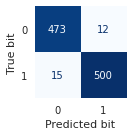

In [25]:
# Get prediction statistics
get_statistics(model, X_test, y_test, model_name, prob=True)

In [26]:
model = SGDClassifier(loss='log', learning_rate='adaptive', eta0=1., tol=1e-3, max_iter=1e4, n_jobs=-1, random_state=seed,
                      verbose=0)
# Select hyperparameters
# ***** test alpha
model.eta0 = test_eta0(model, -5, 6, X_train, y_train, seed)


List of accuracies:         [94.12 91.88 91.5  93.25 93.62]
Mean accuracy:              92.88% +- 1.016%
Incorrectly-predicted keys: 31.25% +- 4.146%
Executed in:                0:00:01
eta0 = 1e+05

List of accuracies:         [94.62 92.38 93.75 93.88 94.  ]
Mean accuracy:              93.72% +- 0.739%
Incorrectly-predicted keys: 27.12% +- 2.867%
Executed in:                0:00:00
eta0 = 1e+04

List of accuracies:         [93.12 93.12 95.38 93.88 93.75]
Mean accuracy:              93.85% +- 0.823%
Incorrectly-predicted keys: 27.00% +- 4.039%
Executed in:                0:00:00
eta0 = 1e+03

List of accuracies:         [92.12 92.88 94.88 93.62 93.88]
Mean accuracy:              93.47% +- 0.930%
Incorrectly-predicted keys: 28.75% +- 4.276%
Executed in:                0:00:00
eta0 = 1e+02

List of accuracies:         [93.   93.75 94.   93.88 94.  ]
Mean accuracy:              93.72% +- 0.374%
Incorrectly-predicted keys: 27.25% +- 2.000%
Executed in:                0:00:00
eta0 = 1e+01


In [27]:
# Train with full training set
model.fit(X_train, y_train)
# lst_acc, lst_wrong_keys = Train_stratCV(model, X_train, y_train, 5, seed)

# Save model
model_name = 'LR2'
joblib.dump(model, f'Results/Models/model_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set:      95.20%
Mean certainty (even if wrong): 97.36%

Incorrectly-predicted keys:     24.00%
Incorrectly-predicted bits:     4.80%

Report: 
               precision    recall  f1-score   support

         0.0      0.954     0.946     0.950       485
         1.0      0.950     0.957     0.954       515

    accuracy                          0.952      1000
   macro avg      0.952     0.952     0.952      1000
weighted avg      0.952     0.952     0.952      1000

Confusion matrix:


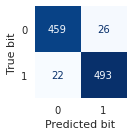

In [28]:
# Get prediction statistics
get_statistics(model, X_test, y_test, model_name, prob=True)

### SVM

#### Linear kernel

In [29]:
model = SVC(kernel='linear', probability=False, tol=1e-3, max_iter=-1, cache_size=1000, random_state=seed, verbose=True)
# Select hyperparameters
# ***** test C

In [30]:
# Train with full training set
model.fit(X_train, y_train)
# lst_acc, lst_wrong_keys = Train_stratCV(model, X_train, y_train, 5, seed)

# Save model
model_name = 'SVM_linear1'
joblib.dump(model, f'Results/Models/model_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set:      97.70%
Incorrectly-predicted keys:     11.50%
Incorrectly-predicted bits:     2.30%

Report: 
               precision    recall  f1-score   support

         0.0      0.966     0.988     0.977       485
         1.0      0.988     0.967     0.977       515

    accuracy                          0.977      1000
   macro avg      0.977     0.977     0.977      1000
weighted avg      0.977     0.977     0.977      1000

Confusion matrix:


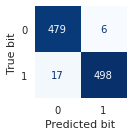

In [31]:
# Get prediction statistics
get_statistics(model, X_test, y_test, model_name)

In [35]:
model = LinearSVC(loss='squared_hinge', dual=False, tol=1e-3, max_iter=1e4, random_state=seed, verbose=1)
# Select hyperparameters
# ***** test C

In [36]:
# Train with full training set
model.fit(X_train, y_train)
# lst_acc, lst_wrong_keys = Train_stratCV(model, X_train, y_train, 5, seed)

# Save model
model_name = 'SVM_linear2'
joblib.dump(model, f'Results/Models/model_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

[LibLinear]

Mean accuracy on test set:      97.80%
Incorrectly-predicted keys:     11.00%
Incorrectly-predicted bits:     2.20%

Report: 
               precision    recall  f1-score   support

         0.0      0.977     0.977     0.977       485
         1.0      0.979     0.979     0.979       515

    accuracy                          0.978      1000
   macro avg      0.978     0.978     0.978      1000
weighted avg      0.978     0.978     0.978      1000

Confusion matrix:


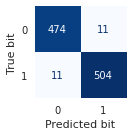

In [37]:
# Get prediction statistics
get_statistics(model, X_test, y_test, model_name)

In [38]:
model = LinearSVC(loss='squared_hinge', dual=True, tol=1e-3, max_iter=1e4, random_state=seed, verbose=1)
# Select hyperparameters
# ***** test C

In [39]:
# Train with full training set
model.fit(X_train, y_train)
# lst_acc, lst_wrong_keys = Train_stratCV(model, X_train, y_train, 5, seed)

# Save model
model_name = 'SVM_linear3'
joblib.dump(model, f'Results/Models/model_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

[LibLinear]

/home/v082327/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean accuracy on test set:      97.80%
Incorrectly-predicted keys:     11.00%
Incorrectly-predicted bits:     2.20%

Report: 
               precision    recall  f1-score   support

         0.0      0.981     0.973     0.977       485
         1.0      0.975     0.983     0.979       515

    accuracy                          0.978      1000
   macro avg      0.978     0.978     0.978      1000
weighted avg      0.978     0.978     0.978      1000

Confusion matrix:


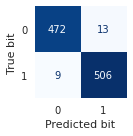

In [40]:
# Get prediction statistics
get_statistics(model, X_test, y_test, model_name)

In [32]:
model = SGDClassifier(loss='hinge', learning_rate='adaptive', eta0=1., tol=1e-3, max_iter=1e4, n_jobs=-1, random_state=seed,
                      verbose=0)
# Select hyperparameters
# ***** test alpha
model.eta0 = test_eta0(model, -5, 6, X_train, y_train, seed)


List of accuracies:         [93.88 89.   93.88 94.25 94.5 ]
Mean accuracy:              93.10% +- 2.064%
Incorrectly-predicted keys: 30.00% +- 8.506%
Executed in:                0:00:00
eta0 = 1e+05

List of accuracies:         [92.5  92.12 94.5  93.   93.12]
Mean accuracy:              93.05% +- 0.809%
Incorrectly-predicted keys: 30.75% +- 3.881%
Executed in:                0:00:00
eta0 = 1e+04

List of accuracies:         [93.25 92.88 94.25 94.12 93.75]
Mean accuracy:              93.65% +- 0.521%
Incorrectly-predicted keys: 27.75% +- 2.669%
Executed in:                0:00:00
eta0 = 1e+03

List of accuracies:         [93.62 94.   93.62 94.38 94.  ]
Mean accuracy:              93.92% +- 0.281%
Incorrectly-predicted keys: 26.88% +- 0.884%
Executed in:                0:00:00
eta0 = 1e+02

List of accuracies:         [94.25 94.5  94.   93.62 93.88]
Mean accuracy:              94.05% +- 0.302%
Incorrectly-predicted keys: 26.12% +- 1.447%
Executed in:                0:00:00
eta0 = 1e+01


In [33]:
# Train with full training set
model.fit(X_train, y_train)
# lst_acc, lst_wrong_keys = Train_stratCV(model, X_train, y_train, 5, seed)

# Save model
model_name = 'SVM_linear4'
joblib.dump(model, f'Results/Models/model_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set:      94.80%
Incorrectly-predicted keys:     25.00%
Incorrectly-predicted bits:     5.20%

Report: 
               precision    recall  f1-score   support

         0.0      0.941     0.953     0.947       485
         1.0      0.955     0.944     0.949       515

    accuracy                          0.948      1000
   macro avg      0.948     0.948     0.948      1000
weighted avg      0.948     0.948     0.948      1000

Confusion matrix:


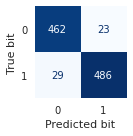

In [34]:
# Get prediction statistics
get_statistics(model, X_test, y_test, model_name)

#### Gaussian kernel

In [41]:
model = SVC(kernel='rbf', gamma='scale', probability=False, tol=1e-3, max_iter=-1, cache_size=1000, random_state=seed,
            verbose=True)
# Select hyperparameters
# ***** test C

In [42]:
# Train with full training set
model.fit(X_train, y_train)
# lst_acc, lst_wrong_keys = Train_stratCV(model, X_train, y_train, 5, seed)

# Save model
model_name = 'SVM_gaussian1'
joblib.dump(model, f'Results/Models/model_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set:      94.20%
Incorrectly-predicted keys:     29.00%
Incorrectly-predicted bits:     5.80%

Report: 
               precision    recall  f1-score   support

         0.0      0.953     0.926     0.939       485
         1.0      0.932     0.957     0.944       515

    accuracy                          0.942      1000
   macro avg      0.943     0.942     0.942      1000
weighted avg      0.942     0.942     0.942      1000

Confusion matrix:


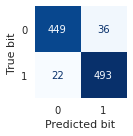

In [43]:
# Get prediction statistics
get_statistics(model, X_test, y_test, model_name)

In [44]:
model = SVC(kernel='rbf', gamma='auto', probability=False, tol=1e-3, max_iter=-1, cache_size=1000, random_state=seed,
            verbose=True)
# Select hyperparameters
# ***** test C

In [45]:
# Train with full training set
model.fit(X_train, y_train)
# lst_acc, lst_wrong_keys = Train_stratCV(model, X_train, y_train, 5, seed)

# Save model
model_name = 'SVM_gaussian2'
joblib.dump(model, f'Results/Models/model_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set:      92.50%
Incorrectly-predicted keys:     37.50%
Incorrectly-predicted bits:     7.50%

Report: 
               precision    recall  f1-score   support

         0.0      0.929     0.915     0.922       485
         1.0      0.921     0.934     0.928       515

    accuracy                          0.925      1000
   macro avg      0.925     0.925     0.925      1000
weighted avg      0.925     0.925     0.925      1000

Confusion matrix:


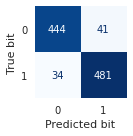

In [46]:
# Get prediction statistics
get_statistics(model, X_test, y_test, model_name)

#### Polynomial kernel

In [47]:
model = SVC(kernel='poly', degree=3, coef0=0., probability=False, tol=1e-3, max_iter=-1, cache_size=1000, random_state=seed,
            verbose=True)
# Select hyperparameters
# ***** test C
model.coef0 = test_coef0(model, -1, 2, X_train, y_train, seed)


List of accuracies:         [99.5  99.5  99.75 99.75 99.75]
Mean accuracy:              99.65% +- 0.122%
Incorrectly-predicted keys:  1.75% +- 0.612%
Executed in:                0:00:01
coef0 = -1

List of accuracies:         [99.62 99.5  99.75 99.75 99.75]
Mean accuracy:              99.68% +- 0.100%
Incorrectly-predicted keys:  1.62% +- 0.500%
Executed in:                0:00:02
coef0 = 0

List of accuracies:         [99.5  99.5  99.75 99.75 99.75]
Mean accuracy:              99.65% +- 0.122%
Incorrectly-predicted keys:  1.75% +- 0.612%
Executed in:                0:00:02
coef0 = 1

Best accuracy:              99.68% ---> coef0 = 0
Incorrectly-predicted keys: 1.62%


In [48]:
# Train with full training set
model.fit(X_train, y_train)
# lst_acc, lst_wrong_keys = Train_stratCV(model, X_train, y_train, 5, seed)

# Save model
model_name = 'SVM_poly1'
joblib.dump(model, f'Results/Models/model_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set:      99.50%
Incorrectly-predicted keys:     2.50%
Incorrectly-predicted bits:     0.50%

Report: 
               precision    recall  f1-score   support

         0.0      0.994     0.996     0.995       485
         1.0      0.996     0.994     0.995       515

    accuracy                          0.995      1000
   macro avg      0.995     0.995     0.995      1000
weighted avg      0.995     0.995     0.995      1000

Confusion matrix:


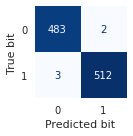

In [51]:
# Get prediction statistics
get_statistics(model, X_test, y_test, model_name)

In [52]:
model = SVC(kernel='poly', degree=4, coef0=0., probability=False, tol=1e-3, max_iter=-1, cache_size=1000, random_state=seed,
            verbose=True)
# Select hyperparameters
# ***** test C
model.coef0 = test_coef0(model, -1, 2, X_train, y_train, seed)


List of accuracies:         [100.   100.   100.    99.88  99.75]
Mean accuracy:              99.92% +- 0.100%
Incorrectly-predicted keys:  0.37% +- 0.500%
Executed in:                0:00:03
coef0 = -1

List of accuracies:         [ 99.88 100.   100.    99.88  99.75]
Mean accuracy:              99.90% +- 0.094%
Incorrectly-predicted keys:  0.50% +- 0.468%
Executed in:                0:00:03
coef0 = 0

List of accuracies:         [ 99.75 100.   100.    99.88  99.75]
Mean accuracy:              99.88% +- 0.112%
Incorrectly-predicted keys:  0.62% +- 0.559%
Executed in:                0:00:03
coef0 = 1

Best accuracy:              99.92% ---> coef0 = -1
Incorrectly-predicted keys: 0.37%


In [53]:
# Train with full training set
model.fit(X_train, y_train)
# lst_acc, lst_wrong_keys = Train_stratCV(model, X_train, y_train, 5, seed)

# Save model
model_name = 'SVM_poly2'
joblib.dump(model, f'Results/Models/model_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set:      99.80%
Incorrectly-predicted keys:     1.00%
Incorrectly-predicted bits:     0.20%

Report: 
               precision    recall  f1-score   support

         0.0      1.000     0.996     0.998       485
         1.0      0.996     1.000     0.998       515

    accuracy                          0.998      1000
   macro avg      0.998     0.998     0.998      1000
weighted avg      0.998     0.998     0.998      1000

Confusion matrix:


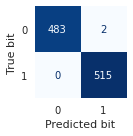

In [54]:
# Get prediction statistics
get_statistics(model, X_test, y_test, model_name)

#### Sigmoid kernel

In [56]:
model = SVC(kernel='sigmoid', gamma='scale', coef0=0., probability=False, tol=1e-3, max_iter=-1, cache_size=1000,
            random_state=seed, verbose=False)
# Select hyperparameters
# ***** test C
model.coef0 = test_coef0(model, -1, 2, X_train, y_train, seed)


List of accuracies:         [51.   51.   51.   50.88 50.88]
Mean accuracy:              50.95% +- 0.061%
Incorrectly-predicted keys: 96.12% +- 1.500%
Executed in:                0:00:08
coef0 = -1

List of accuracies:         [51.   51.   51.   50.88 50.88]
Mean accuracy:              50.95% +- 0.061%
Incorrectly-predicted keys: 96.12% +- 1.500%
Executed in:                0:00:08
coef0 = 0

List of accuracies:         [51.   51.   51.   50.88 50.88]
Mean accuracy:              50.95% +- 0.061%
Incorrectly-predicted keys: 96.12% +- 1.500%
Executed in:                0:00:07
coef0 = 1

Best accuracy:              50.95% ---> coef0 = -1
Incorrectly-predicted keys: 96.12%


In [57]:
# Train with full training set
model.fit(X_train, y_train)
# lst_acc, lst_wrong_keys = Train_stratCV(model, X_train, y_train, 5, seed)

# Save model
model_name = 'SVM_sigmoid1'
joblib.dump(model, f'Results/Models/model_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set:      51.50%
Incorrectly-predicted keys:     96.50%
Incorrectly-predicted bits:     48.50%

Report: 
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000       485
         1.0      0.515     1.000     0.680       515

    accuracy                          0.515      1000
   macro avg      0.258     0.500     0.340      1000
weighted avg      0.265     0.515     0.350      1000

Confusion matrix:


/home/v082327/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v082327/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v082327/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


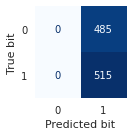

In [58]:
# Get prediction statistics
get_statistics(model, X_test, y_test, model_name)

In [59]:
model = SVC(kernel='sigmoid', gamma='auto', coef0=0., probability=False, tol=1e-3, max_iter=-1, cache_size=1000,
            random_state=seed, verbose=False)
# Select hyperparameters
# ***** test C
model.coef0 = test_coef0(model, -1, 2, X_train, y_train, seed)


List of accuracies:         [51.   51.   51.   50.88 50.88]
Mean accuracy:              50.95% +- 0.061%
Incorrectly-predicted keys: 96.12% +- 1.500%
Executed in:                0:00:03
coef0 = -1

List of accuracies:         [51.   51.   51.   50.88 50.88]
Mean accuracy:              50.95% +- 0.061%
Incorrectly-predicted keys: 96.12% +- 1.500%
Executed in:                0:00:03
coef0 = 0

List of accuracies:         [51.   51.   51.   50.88 50.88]
Mean accuracy:              50.95% +- 0.061%
Incorrectly-predicted keys: 96.12% +- 1.500%
Executed in:                0:00:03
coef0 = 1

Best accuracy:              50.95% ---> coef0 = -1
Incorrectly-predicted keys: 96.12%


In [60]:
# Train with full training set
model.fit(X_train, y_train)
# lst_acc, lst_wrong_keys = Train_stratCV(model, X_train, y_train, 5, seed)

# Save model
model_name = 'SVM_sigmoid2'
joblib.dump(model, f'Results/Models/model_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set:      51.50%
Incorrectly-predicted keys:     96.50%
Incorrectly-predicted bits:     48.50%

Report: 
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000       485
         1.0      0.515     1.000     0.680       515

    accuracy                          0.515      1000
   macro avg      0.258     0.500     0.340      1000
weighted avg      0.265     0.515     0.350      1000

Confusion matrix:


/home/v082327/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v082327/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v082327/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


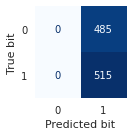

In [61]:
# Get prediction statistics
get_statistics(model, X_test, y_test, model_name)

### Naïve Bayes

#### Gaussian NB

In [62]:
model = GaussianNB(var_smoothing=1e-9)
# Select hyperparameters
# ***** test var_smoothing

In [63]:
# Train with full training set
model.fit(X_train, y_train)
# lst_acc, lst_wrong_keys = Train_stratCV(model, X_train, y_train, 5, seed)

# Save model
model_name = 'NB_gaussian'
joblib.dump(model, f'Results/Models/model_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set:      89.10%
Mean certainty (even if wrong): 94.99%

Incorrectly-predicted keys:     40.00%
Incorrectly-predicted bits:     10.90%

Report: 
               precision    recall  f1-score   support

         0.0      0.852     0.938     0.893       485
         1.0      0.936     0.847     0.889       515

    accuracy                          0.891      1000
   macro avg      0.894     0.892     0.891      1000
weighted avg      0.895     0.891     0.891      1000

Confusion matrix:


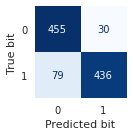

In [64]:
# Get prediction statistics
get_statistics(model, X_test, y_test, model_name, prob=True)

#### Multinomial NB

In [65]:
model = MultinomialNB(alpha=1.) # does not work with negative values
# Select hyperparameters
# ***** test alpha

In [66]:
# Train with full training set
model.fit(X_train, y_train)
# lst_acc, lst_wrong_keys = Train_stratCV(model, X_train, y_train, 5, seed)

# Save model
model_name = 'NB_multi'
joblib.dump(model, f'Results/Models/model_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

model.n_features_in_#, model.feature_count_

30

Mean accuracy on test set:      71.30%
Mean certainty (even if wrong): 80.42%

Incorrectly-predicted keys:     74.50%
Incorrectly-predicted bits:     28.70%

Report: 
               precision    recall  f1-score   support

         0.0      0.702     0.709     0.706       485
         1.0      0.724     0.717     0.720       515

    accuracy                          0.713      1000
   macro avg      0.713     0.713     0.713      1000
weighted avg      0.713     0.713     0.713      1000

Confusion matrix:


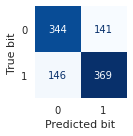

In [67]:
# Get prediction statistics
get_statistics(model, X_test, y_test, model_name, prob=True)

#### Categorical NB

In [68]:
model = CategoricalNB(alpha=0.001, min_categories=1) # does not work with negative values
# Select hyperparameters
# ***** test alpha & min_categories

In [69]:
# Train with full training set
model.fit(X_train, y_train)
# lst_acc, lst_wrong_keys = Train_stratCV(model, X_train, y_train, 5, seed)

# Save model
model_name = 'NB_cat'
joblib.dump(model, f'Results/Models/model_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

model.n_features_in_, model.n_categories_

(30,
 array([16,  8, 16,  8, 16,  8, 16,  8,  7,  8, 14, 16, 14,  8,  8,  8,  8,
        14, 16, 14,  8,  8,  8,  8, 14, 16, 14,  8,  8,  8]))

Mean accuracy on test set:      83.10%
Mean certainty (even if wrong): 94.17%

Incorrectly-predicted keys:     48.50%
Incorrectly-predicted bits:     16.90%

Report: 
               precision    recall  f1-score   support

         0.0      0.832     0.816     0.824       485
         1.0      0.830     0.845     0.837       515

    accuracy                          0.831      1000
   macro avg      0.831     0.831     0.831      1000
weighted avg      0.831     0.831     0.831      1000

Confusion matrix:


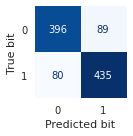

In [70]:
# Get prediction statistics
get_statistics(model, X_test, y_test, model_name, prob=True)

### Decision tree

In [83]:
model = DecisionTreeClassifier(criterion=None, max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=None,
                               random_state=seed)
# Select hyperparameters
best_par = test_trees(model, X_train, y_train, seed,
                      criterion=['gini', 'entropy'],
                      max_depth=[5, 10, 20, 30, None],
                      # max_features=[0.25, 0.5, 0.75, None],
                      # max_leaf_nodes=range(2, 21),
                      min_impurity_decrease=[*(10.**-np.arange(1, 8))]+[0.]
                     )
model.criterion             = best_par[0]
model.max_depth             = best_par[1]
model.max_features          = best_par[2]
model.max_leaf_nodes        = best_par[3]
model.min_impurity_decrease = best_par[4]


List of accuracies:         [89.25 88.62 89.38 89.38 90.75]
Mean accuracy:              89.47% +- 0.696%
Incorrectly-predicted keys: 43.50% +- 2.812%
Executed in:                0:00:00
gini, 5, None, None, 1e-01

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predicted keys:  0.25% +- 0.306%
Executed in:                0:00:00
gini, 5, None, None, 1e-02

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predicted keys:  0.25% +- 0.306%
Executed in:                0:00:00
gini, 5, None, None, 1e-03

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predicted keys:  0.25% +- 0.306%
Executed in:                0:00:00
gini, 5, None, None, 1e-04

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predic


List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predicted keys:  0.25% +- 0.306%
Executed in:                0:00:00
gini, None, None, None, 1e-07

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predicted keys:  0.25% +- 0.306%
Executed in:                0:00:00
gini, None, None, None, 0e+00

List of accuracies:         [96.88 98.12 97.75 97.75 97.75]
Mean accuracy:              97.65% +- 0.414%
Incorrectly-predicted keys: 11.00% +- 1.225%
Executed in:                0:00:00
entropy, 5, None, None, 1e-01

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predicted keys:  0.25% +- 0.306%
Executed in:                0:00:00
entropy, 5, None, None, 1e-02

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorr


List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predicted keys:  0.25% +- 0.306%
Executed in:                0:00:00
entropy, None, None, None, 1e-04

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predicted keys:  0.25% +- 0.306%
Executed in:                0:00:00
entropy, None, None, None, 1e-05

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predicted keys:  0.25% +- 0.306%
Executed in:                0:00:00
entropy, None, None, None, 1e-06

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predicted keys:  0.25% +- 0.306%
Executed in:                0:00:00
entropy, None, None, None, 1e-07

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95%

In [85]:
# Select hyperparameters again - min_impurity_decrease
if model.min_impurity_decrease != 0.:
    best_par = test_trees(model, X_train, y_train, seed,
                          criterion=[model.criterion],
                          max_depth=[model.max_depth],
                          # max_features=[0.25, 0.5, 0.75, None],
                          # max_leaf_nodes=range(2, 21),
                          min_impurity_decrease=model.min_impurity_decrease*np.asarray([0.2, 0.4, 0.6, 0.8, 1, 2, 4, 6, 8])
                         )
    model.criterion             = best_par[0]
    model.max_depth             = best_par[1]
    model.max_features          = best_par[2]
    model.max_leaf_nodes        = best_par[3]
    model.min_impurity_decrease = best_par[4]


List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predicted keys:  0.25% +- 0.306%
Executed in:                0:00:00
gini, 5, None, None, 2e-03

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predicted keys:  0.25% +- 0.306%
Executed in:                0:00:00
gini, 5, None, None, 4e-03

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predicted keys:  0.25% +- 0.306%
Executed in:                0:00:00
gini, 5, None, None, 6e-03

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predicted keys:  0.25% +- 0.306%
Executed in:                0:00:00
gini, 5, None, None, 8e-03

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-p

In [87]:
# Select hyperparameters again - max_depth
if model.max_depth != None:
    best_par = test_trees(model, X_train, y_train, seed,
                          criterion=[model.criterion],
                          max_depth=model.max_depth+np.arange(-4, 5),
                          # max_features=[0.25, 0.5, 0.75, None],
                          # max_leaf_nodes=range(2, 21),
                          min_impurity_decrease=[model.min_impurity_decrease]
                         )
    model.criterion             = best_par[0]
    model.max_depth             = best_par[1]
    model.max_features          = best_par[2]
    model.max_leaf_nodes        = best_par[3]
    model.min_impurity_decrease = best_par[4]


List of accuracies:         [89.25 88.62 89.38 89.38 90.75]
Mean accuracy:              89.47% +- 0.696%
Incorrectly-predicted keys: 43.50% +- 2.812%
Executed in:                0:00:00
gini, 1, None, None, 2e-03

List of accuracies:         [90.   89.38 90.75 88.88 89.88]
Mean accuracy:              89.77% +- 0.629%
Incorrectly-predicted keys: 39.38% +- 3.162%
Executed in:                0:00:00
gini, 2, None, None, 2e-03

List of accuracies:         [96.88 98.12 97.75 97.75 97.75]
Mean accuracy:              97.65% +- 0.414%
Incorrectly-predicted keys: 11.00% +- 1.225%
Executed in:                0:00:00
gini, 3, None, None, 2e-03

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predicted keys:  0.25% +- 0.306%
Executed in:                0:00:00
gini, 4, None, None, 2e-03

List of accuracies:         [ 99.88 100.    99.88 100.   100.  ]
Mean accuracy:              99.95% +- 0.061%
Incorrectly-predicted keys: 

In [88]:
# Train with full training set
model.fit(X_train, y_train)
# lst_acc, lst_wrong_keys = Train_stratCV(model, X_train, y_train, 5, seed)
# cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, verbose=1)

# Save model
model_name = 'DT'
joblib.dump(model, f'Results/Models/model_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

model.get_depth(), model.get_n_leaves()

(4, 5)

Mean accuracy on test set:      100.00%
Mean certainty (even if wrong): 100.00%

Incorrectly-predicted keys:     0.00%
Incorrectly-predicted bits:     0.00%

Report: 
               precision    recall  f1-score   support

         0.0      1.000     1.000     1.000       485
         1.0      1.000     1.000     1.000       515

    accuracy                          1.000      1000
   macro avg      1.000     1.000     1.000      1000
weighted avg      1.000     1.000     1.000      1000

Confusion matrix:


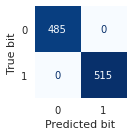

In [89]:
# Get prediction statistics
get_statistics(model, X_test, y_test, model_name, prob=True)

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(model, filled=True, rounded=True, special_characters=True)
                           # feature_names=df.columns[:-n], class_names=['0','1']

# Draw tree
graph = graphviz.Source(dot_data)
graph.render(f'Results/Other/DT_{nb_name}_low_sampling={sampling_interval}_noisy_power_per_gate_noisestd={noise_std}', cleanup=True)
graph

## To-do?

### Random forest

### Gradient-boosting

### KNN

### Neural network